# **Detecção de spam em e-mails**

## Grupo: Gil de Almeida Alves, Pedro Bruce de Lima e Thiago César Castilho Almeida

## Importando as Bibliotecas

In [ ]:
# Data Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PLN

import spacy
try:
  nlp = spacy.load("en_core_web_sm")
except:
  !python -m spacy download en_core_web_sm
  nlp = spacy.load("en_core_web_sm")

import nltk
from nltk.corpus import stopwords

# Avaliação

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Tokenização

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# Modelagem

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier

## Carregamento do Dataset

In [ ]:
data = pd.read_csv('/content/messages.csv')

data.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2831 non-null   object
 1   message  2893 non-null   object
 2   label    2893 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


In [ ]:
data.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [ ]:
data['label'].value_counts()

0    2412
1     481
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

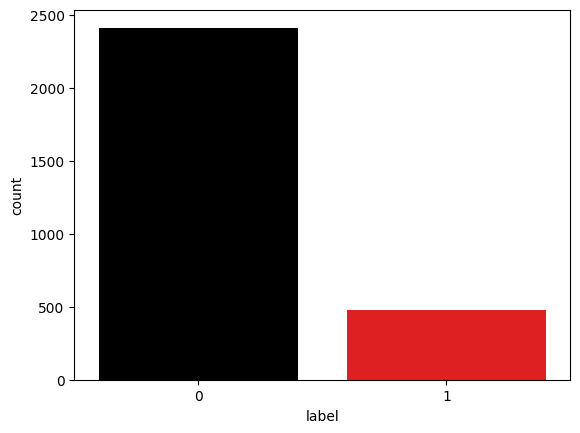

In [ ]:
sns.countplot(x='label', data=data, palette=['#000000',"#FF0000"])

## Pré-processamento

Aqui serão realizadas algumas tarefas para pré-processar o texto das colunas.

Os algoritmos de aprendizado de máquina não estão preparados para receber qualquer tipo de dado.

Quando falamos de Processamento de Linguagem Natural (PLN), temos que os dados na maioria das vezes não estão estruturados, sendo necessário realizar uma padronização dos textos, para que seja possível aos algoritmos manipulá-los. Mesmo que os dados/textos venham do mesmo lugar, isso não significa que estão escritos da mesma forma.

Algumas características que merecem a nossa atenção são:

*   Substituição de letras capitalizadas;
*   Remoção de Stop words;
*   Lematização;
*   Substituição de símbolos e números;
*   Descontração (Inglês);
*   etc;

Aqui serão realizadas algumas dessas técnicas.



Primeiro, devemos realizar a remoção dos valores nulos. Para isso, iremos substituir os valores nulos pela moda.

In [ ]:
data.fillna(data['subject'].mode().values[0],inplace=True)

Uma estratégia que será utilizada será o truncamento do assunto do email com a mensagem. Como ambas as características são textos, isso poderá poupar-nos trabalho.

In [ ]:
data['email'] = data['subject'] + ' ' + data['message']

data['email'][1]

'sociolinguistics lang classification grimes , joseph e . and barbara f . grimes ; ethnologue language family index ; pb . isbn : 0-88312 - 708 - 3 ; vi , 116 pp . ; $ 14 . 00 . summer institute of linguistics . this companion volume to ethnologue : languages of the world , twelfth edition lists language families of the world with sub-groups shown in a tree arrangement under the broadest classification of language family . the language family index facilitates locating language names in the ethnologue , making the data there more accessible . internet : academic . books @ sil . org languages , reference lang & culture gregerson , marilyn ; ritual , belief , and kinship in sulawesi ; pb . : isbn : 0-88312 - 621 - 4 ; ix , 194 pp . ; $ 25 . 00 . summer institute of linguistics . seven articles discuss five language groups in sulawesi , indonesia ; the primary focus is on cultural matters , with some linguistic content . topics include traditional religion and beliefs , certain ceremonies

In [ ]:
# Remover as quebras de linha

data['email'] = data['email'].str.replace(r'\n',"")

data['email'][302]

<ipython-input-9-8496ac7ce596>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['email'] = data['email'].str.replace(r'\n',"")


'changes in the journal language the editorial staff and offices of the journal language have been changed as of this month . articles for submission and general correspondence should be sent to the following address : mark aronoff , editor language department of linguistics suny stony brook stony brook , ny 11794-4376 , usa book reviews and all correspondence concerning reviews should be sent to the following address : edwin battistella , review editor language division of humanities wayne state college wayne , ne 68787 , usa both offices may be reached by email : main office : language . eds @ sunysb . edu review office : langrev @ wscgate . wsc . edu the main office may be reached by telephone : phone : 1-516 - 632-8003 fax : 1-516 - 632-9468'

In [ ]:
# Substitui o símbolo '$'

data['email']=data['email'].str.replace(r'\$', 'money')

data['email'][2887]

<ipython-input-10-cbe37b62f20f>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['email']=data['email'].str.replace(r'\$', 'money')


"win money 300usd and a cruise ! raquel 's casino , inc . is awarding a cruise + money 300 to a lucky member . no purchase necessary to play ! join before month end to participate . ( you will automatically be enteredinto the next drawing . ) you can join at http : / / www . raquelscasino . com ( casino ) http : / / www . tobet . com ( sportsbook ) raquel 's online casino provides guests with a state-of - the-art gaming experience : - a chance to win a cruise and money 300 ! - 10 % sign-up bonus ! - free casino software ! - 25 casino games ! - international sportsbook ! - horse racing ! - play for fun , or for real ! our casino is secure , audited , private , and insured . thank you for your time and consideration . * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *"

In [ ]:
# Substitui números de telefone
# Aqui, nem todos os números de telefone são substituídos corretamente, mas a maioria deles sim.

data['email']=data['email'].str.replace("(.?){0,2}\d?(\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4})", "phonenumber")
data['email']=data['email'].str.replace("\\+?\\d{1,4}?[-.\\s]?\\(?\\d{1,3}?\\)?[-.\\s]?\\d{1,4}[-.\\s]?\\d{1,4}[-.\\s]?\\d{1,9}", "phonenumber")

data['email'][302]

<ipython-input-11-041b3a949149>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data['email']=data['email'].str.replace("(.?){0,2}\d?(\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4})", "phonenumber")
<ipython-input-11-041b3a949149>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data['email']=data['email'].str.replace("\\+?\\d{1,4}?[-.\\s]?\\(?\\d{1,3}?\\)?[-.\\s]?\\d{1,4}[-.\\s]?\\d{1,4}[-.\\s]?\\d{1,9}", "phonenumber")


'changes in the journal language the editorial staff and offices of the journal language have been changed as of this month . articles for submission and general correspondence should be sent to the following address : mark aronoff , editor language department of linguistics suny stony brook stony brook , ny phonenumber , usa book reviews and all correspondence concerning reviews should be sent to the following address : edwin battistella , review editor language division of humanities wayne state college wayne , ne phonenumber , usa both offices may be reached by email : main office : language . eds @ sunysb . edu review office : langrev @ wscgate . wsc . edu the main office may be reached by telephone : phone : phonenumber fax : phonenumber'

In [ ]:
# data['email'][119]

In [ ]:
# Substitui numeros por 'number '

data['email']=data['email'].str.replace(r'\d+(\.\d+)?', 'number ')
data['email'][302]

<ipython-input-13-b87298179df9>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['email']=data['email'].str.replace(r'\d+(\.\d+)?', 'number ')


'changes in the journal language the editorial staff and offices of the journal language have been changed as of this month . articles for submission and general correspondence should be sent to the following address : mark aronoff , editor language department of linguistics suny stony brook stony brook , ny phonenumber , usa book reviews and all correspondence concerning reviews should be sent to the following address : edwin battistella , review editor language division of humanities wayne state college wayne , ne phonenumber , usa both offices may be reached by email : main office : language . eds @ sunysb . edu review office : langrev @ wscgate . wsc . edu the main office may be reached by telephone : phone : phonenumber fax : phonenumber'

In [ ]:
data['email'][2887]

"win money number usd and a cruise ! raquel 's casino , inc . is awarding a cruise + money number  to a lucky member . no purchase necessary to play ! join before month end to participate . ( you will automatically be enteredinto the next drawing . ) you can join at http : / / www . raquelscasino . com ( casino ) http : / / www . tobet . com ( sportsbook ) raquel 's online casino provides guests with a state-of - the-art gaming experience : - a chance to win a cruise and money number  ! - number  % sign-up bonus ! - free casino software ! - number  casino games ! - international sportsbook ! - horse racing ! - play for fun , or for real ! our casino is secure , audited , private , and insured . thank you for your time and consideration . * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *"

In [ ]:
# Remove caracteres especiais (tem que ser o último por causa das url, email, etc)

data['email']=data['email'].str.replace(r"[^a-zA-Z0-9@]+", " ")

data['email'][1]

<ipython-input-15-f82ff65a652d>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data['email']=data['email'].str.replace(r"[^a-zA-Z0-9@]+", " ")


'sociolinguistics lang classification grimes joseph e and barbara f grimes ethnologue language family index pb isbn phonenumber number number vi number pp money number number summer institute of linguistics this companion volume to ethnologue languages of the world twelfth edition lists language families of the world with sub groups shown in a tree arrangement under the broadest classification of language family the language family index facilitates locating language names in the ethnologue making the data there more accessible internet academic books @ sil org languages reference lang culture gregerson marilyn ritual belief and kinship in sulawesi pb isbn phonenumber number number ix number pp money number number summer institute of linguistics seven articles discuss five language groups in sulawesi indonesia the primary focus is on cultural matters with some linguistic content topics include traditional religion and beliefs certain ceremonies and kinship internet academic books @ sil

In [ ]:
# Remover stop words (palavras que são comuns e não possuem valor nas frases)

nltk.download('stopwords')
swords = nlp.Defaults.stop_words

sw = list(set(stopwords.words('english') + list(swords)))

data['email'] = data['email'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))

data['email'][1]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'sociolinguistics lang classification grimes joseph e barbara f grimes ethnologue language family index pb isbn phonenumber number number vi number pp money number number summer institute linguistics companion volume ethnologue languages world twelfth edition lists language families world sub groups shown tree arrangement broadest classification language family language family index facilitates locating language names ethnologue making data accessible internet academic books @ sil org languages reference lang culture gregerson marilyn ritual belief kinship sulawesi pb isbn phonenumber number number ix number pp money number number summer institute linguistics seven articles discuss language groups sulawesi indonesia primary focus cultural matters linguistic content topics include traditional religion beliefs certain ceremonies kinship internet academic books @ sil org language society indonesia computers ling weber david j stephen r mcconnel diana weber beth j bryson primer tool develo

In [ ]:
# aqui a lematização estava ficando longa e com problemas. Encontramos solução aqui
# https://stackoverflow.com/questions/75214153/lemmatization-taking-forever-with-spacy
# Process large text as a stream via `nlp.pipe()` and iterate over the results, extracting lemmas
lemma_text_list = []
for doc in nlp.pipe(data["email"]):
    lemma_text_list.append(" ".join(token.lemma_ for token in doc))
data["email"] = lemma_text_list

data['email'][1]

'sociolinguistic lang classification grime joseph e barbara f grime ethnologue language family index pb isbn phonenumber number number vi number pp money number number summer institute linguistics companion volume ethnologue language world twelfth edition list language family world sub group show tree arrangement broad classification language family language family index facilitate locate language name ethnologue make datum accessible internet academic book @ sil org language reference lang culture gregerson marilyn ritual belief kinship sulawesi pb isbn phonenumber number number ix number pp money number number summer institute linguistic seven article discuss language group sulawesi indonesia primary focus cultural matter linguistic content topic include traditional religion belief certain ceremony kinship internet academic book @ sil org language society indonesia computer le weber david j stephen r mcconnel diana weber beth j bryson primer tool develop early reading material pb isb

In [ ]:
data['email'][5]

'abstract optimality syntactic theory content length number paper good good workshop optimality syntactic theory hold massachusetts institute technology cambridge phonenumber syntactic research variety framework assign grow role notion comparison work forefront current research include theory involve principle economy optimality work unpublished formative stage legendre raymond smolensky number grimshaw number pesetsky number chomsky number number number relevant datum vary account empirical comparison proposal undertake number number number mit host workshop explore clarify particular issue syntactic theory comparison play significant role workshop consist invite talk talk select anonymously submit abstract abstract invite address follow question nature candidate reference set comparison linguistic object compete good choice criterion determine optimal output set candidate grammar compare derivation economy principle chomsky number number representation optimality theoretic analysis d

In [ ]:
data['email'][0]

'job post apple iss research center content length number apple iss research center money number million joint venture apple computer inc institute systems science national university singapore locate singapore look senior speech scientist successful candidate research expertise computational linguistic include natural language process english chinese statistical language model knowledge state art corpus base n gram language model cache language model speech language model require text speech project leader successful candidate research expertise expertise follow area computational linguistic include natural language parse lexical database design statistical language model text tokenization normalization prosodic analysis substantial knowledge phonology syntax semantics chinese require knowledge acoustic phonetics speech signal processing desirable candidate phd number number year relevant work experience technical msc degree number number year experienc e strong software engineering s

In [ ]:
data = data.drop(['message', 'subject'], axis=1)

In [ ]:
data

,label,email
0,0,job post apple iss research center content len...
1,0,sociolinguistic lang classification grime jose...
2,0,query letter frequency text identification pos...
3,0,risk colleague research differ degree risk per...
4,0,request book information early morning phone f...
...,...,...
2888,1,love profile ysuolvpv hello thank stop take ne...
2889,1,ask join kiddin list owner kiddin invite join ...
2890,0,anglicization composer name judge return post ...
2891,0,number number comparative method n ary compari...


In [ ]:
# tentamos buscar alguma relação entre o tamanho da mensagem e a label, mas não funcionou muito bem

data['length'] = data.email.apply(len)
data.head()

,label,email,length
0,0,job post apple iss research center content len...,1983
1,0,sociolinguistic lang classification grime jose...,1431
2,0,query letter frequency text identification pos...,930
3,0,risk colleague research differ degree risk per...,180
4,0,request book information early morning phone f...,557


## Tokenização

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.email, data.label, test_size = 0.3, stratify=data.label)

print(X_train)

81      reference non human language content length nu...
2682    program indigenous language brazil typo recent...
1650    sum frequency week ago query linguist list fre...
807     special offer eu workshop esslli number novelt...
698     contragram number quarterly newsletter contras...
                              ...                        
1899    december conference preliminary announcement i...
139     ems good software good money remove instructio...
1662    pragmatic critical concept pragmatic critical ...
249     sum c gemination syntactic content length phon...
1399    scil number paper student conference linguisti...
Name: email, Length: 2025, dtype: object


In [ ]:
vectorizer = TfidfVectorizer(min_df=3) # minimo de ocorrencias

X = vectorizer.fit_transform(X_train)

vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aaai', ..., 'zwicky', 'zwischen', 'zygmunt'],
      dtype=object)

In [ ]:
print(vectorizer.get_stop_words())

None


In [ ]:
pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

,aa,aaa,aaai,aachen,aalborg,aamodt,aamt,aan,aarhus,aaron,...,zuber,zubizarreta,zum,zur,zurich,zwart,zweigenbaum,zwicky,zwischen,zygmunt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# SVM

In [ ]:
svm = SVC()

In [ ]:
pipe = Pipeline(steps=[("vectorizer", vectorizer), ("classifier", svm)])

param_grid = {"classifier__kernel":['linear', 'poly', 'rbf', 'sigmoid'], "classifier__C":[1, 3, 7]}

best_svm = GridSearchCV(pipe, param_grid, scoring=('f1_weighted'), cv=3)

model_svm = best_svm.fit(X_train, y_train)

df = pd.DataFrame(best_svm.cv_results_)

df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.754036,0.094511,0.348751,0.048496,1,linear,"{'classifier__C': 1, 'classifier__kernel': 'li...",0.995531,0.994031,0.986545,0.992036,0.003930,5
1,1.749475,0.041181,0.796575,0.012761,1,poly,"{'classifier__C': 1, 'classifier__kernel': 'po...",0.903179,0.871276,0.889010,0.887822,0.013052,12
2,1.491933,0.207413,0.510102,0.036401,1,rbf,"{'classifier__C': 1, 'classifier__kernel': 'rbf'}",0.981813,0.980257,0.978787,0.980286,0.001235,9
3,0.547564,0.032943,0.249093,0.006882,1,sigmoid,"{'classifier__C': 1, 'classifier__kernel': 'si...",0.997026,0.992524,0.986545,0.992032,0.004293,6
4,0.593710,0.023833,0.277759,0.001592,3,linear,"{'classifier__C': 3, 'classifier__kernel': 'li...",0.995531,0.995531,0.986545,0.992536,0.004236,3
5,1.906179,0.208762,0.814369,0.030924,3,poly,"{'classifier__C': 3, 'classifier__kernel': 'po...",0.909125,0.882348,0.897299,0.896257,0.010956,10
6,1.391320,0.052139,0.486785,0.008649,3,rbf,"{'classifier__C': 3, 'classifier__kernel': 'rbf'}",0.984904,0.984904,0.978787,0.982865,0.002884,7
7,0.631665,0.087897,0.314577,0.045490,3,sigmoid,"{'classifier__C': 3, 'classifier__kernel': 'si...",0.998516,0.997026,0.988062,0.994535,0.004617,2
8,0.595559,0.034031,0.281626,0.001853,7,linear,"{'classifier__C': 7, 'classifier__kernel': 'li...",0.995531,0.995531,0.986545,0.992536,0.004236,3
9,1.816115,0.022500,0.886468,0.139044,7,poly,"{'classifier__C': 7, 'classifier__kernel': 'po...",0.909125,0.882348,0.897299,0.896257,0.010956,10


In [ ]:
best_svm.best_params_

{'classifier__C': 7, 'classifier__kernel': 'sigmoid'}

In [ ]:
y_pred = model_svm.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)

matrix

array([[723,   1],
       [  7, 137]])

Text(50.722222222222214, 0.5, 'Truth')

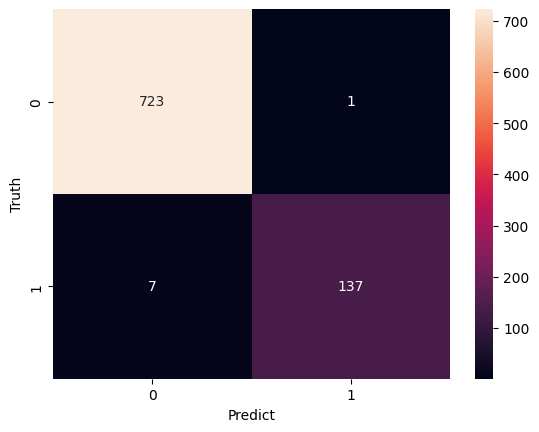

In [ ]:
# Criando um heatmap para melhor visualização

plt.figure()
sns.heatmap(matrix, annot=True, fmt='g')
plt.xlabel("Predict")
plt.ylabel("Truth")

In [ ]:
print("Accuracy: ", accuracy_score(y_pred,y_test))
print("Precision: ", precision_score(y_pred,y_test, average = 'weighted'))
print("Recall: ", recall_score(y_pred,y_test, average = 'weighted'))
print("F1 Score: ", f1_score(y_pred,y_test, average = 'weighted'))

Accuracy:  0.9907834101382489
Precision:  0.9911098840712547
Recall:  0.9907834101382489
F1 Score:  0.9908624426188452


# Naive Bayes

In [ ]:
nb = MultinomialNB()

In [ ]:
pipe = Pipeline([('vectorizer',vectorizer),('classifier',nb)])
model_nb = pipe.fit(X_train,y_train)

In [ ]:
y_pred = model_nb.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)

matrix

array([[724,   0],
       [ 50,  94]])

Text(50.722222222222214, 0.5, 'Truth')

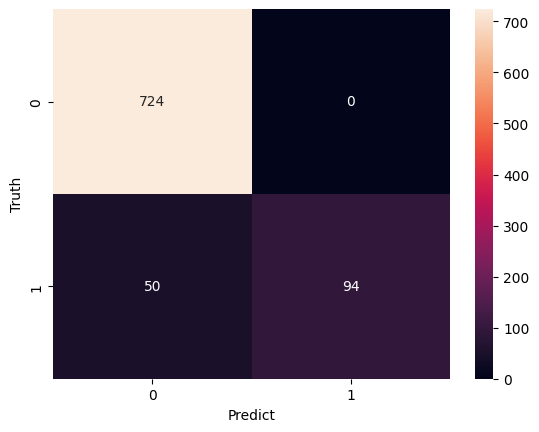

In [ ]:
# Criando um heatmap para melhor visualização

plt.figure()
sns.heatmap(matrix, annot=True, fmt='g')
plt.xlabel("Predict")
plt.ylabel("Truth")

In [ ]:
print("Accuracy: ", accuracy_score(y_pred,y_test))
print("Precision: ", precision_score(y_pred,y_test, average = 'weighted'))
print("Recall: ", recall_score(y_pred,y_test, average = 'weighted'))
print("F1 Score: ", f1_score(y_pred,y_test, average = 'weighted'))

Accuracy:  0.9423963133640553
Precision:  0.9623975934459805
Recall:  0.9423963133640553
F1 Score:  0.9474857775488851


# kNN

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
pipe = Pipeline(steps=[("vectorizer", vectorizer), ("classifier", KNeighborsClassifier())])

param_grid = {'classifier__n_neighbors':[1, 3, 5, 7], 'classifier__p':[1, 2]}

best_knn = GridSearchCV(pipe, param_grid, scoring=('f1_weighted'), cv=3)

model_knn = best_knn.fit(X_train, y_train)

df = pd.DataFrame(best_knn.cv_results_)

df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_neighbors,param_classifier__p,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.292300,0.067292,0.607887,0.131824,1,1,"{'classifier__n_neighbors': 1, 'classifier__p'...",0.059236,0.758617,0.756535,0.524796,0.329202,8
1,0.227909,0.009553,12.710433,0.106725,1,2,"{'classifier__n_neighbors': 1, 'classifier__p'...",0.967169,0.943429,0.914688,0.941762,0.021458,4
2,0.223617,0.007112,0.408938,0.008886,3,1,"{'classifier__n_neighbors': 3, 'classifier__p'...",0.779185,0.758617,0.756535,0.764779,0.010222,5
3,0.221915,0.009245,12.713969,0.085918,3,2,"{'classifier__n_neighbors': 3, 'classifier__p'...",0.979259,0.972282,0.933920,0.961820,0.019933,3
4,0.269681,0.068372,0.536532,0.117852,5,1,"{'classifier__n_neighbors': 5, 'classifier__p'...",0.758617,0.758617,0.756535,0.757923,0.000981,6
5,0.276770,0.073718,12.687662,0.088695,5,2,"{'classifier__n_neighbors': 5, 'classifier__p'...",0.974860,0.972096,0.950628,0.965861,0.010831,2
6,0.227601,0.018061,0.407170,0.006799,7,1,"{'classifier__n_neighbors': 7, 'classifier__p'...",0.758617,0.758617,0.756535,0.757923,0.000981,6
7,0.231002,0.001900,12.643522,0.163665,7,2,"{'classifier__n_neighbors': 7, 'classifier__p'...",0.973520,0.976462,0.949095,0.966359,0.012266,1


In [ ]:
best_knn.best_params_

{'classifier__n_neighbors': 7, 'classifier__p': 2}

In [ ]:
y_pred = model_knn.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)

matrix

array([[706,  18],
       [ 12, 132]])

Text(50.722222222222214, 0.5, 'Truth')

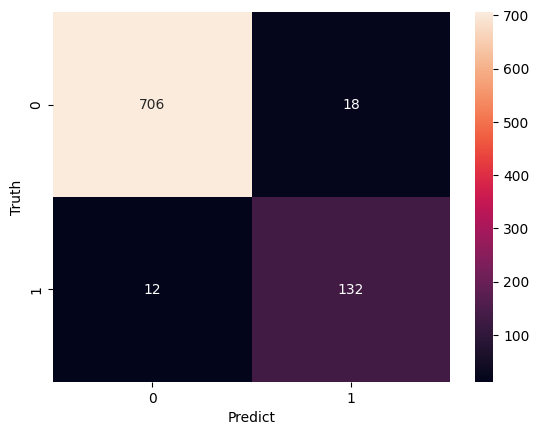

In [ ]:
# Criando um heatmap para melhor visualização

plt.figure()
sns.heatmap(matrix, annot=True, fmt='g')
plt.xlabel("Predict")
plt.ylabel("Truth")

In [ ]:
print("Accuracy: ", accuracy_score(y_pred,y_test))
print("Precision: ", precision_score(y_pred,y_test, average = 'weighted'))
print("Recall: ", recall_score(y_pred,y_test, average = 'weighted'))
print("F1 Score: ", f1_score(y_pred,y_test, average = 'weighted'))

Accuracy:  0.9654377880184332
Precision:  0.9650336074547445
Recall:  0.9654377880184332
F1 Score:  0.9651570171265678
